In [1]:
import xarray as xr
import numpy as np

from xcube.core.rectify import rectify_dataset, ImageGeom, GeoCoding
from xcube.core.sentinel3 import open_sentinel3_product
from xcube.util.perf import measure_time

xr.set_options(display_style="html")

Setup local, CPU-based dask cluster:

In [2]:
allow_client_scheduler = False
client = None

In [3]:
if allow_client_scheduler:
    from dask.distributed import Client
    client = None
    if client is not None:
        client.close()
    client = Client()
client

Define a fake-logger. The normal logger output does not appear in notebooks.

In [4]:
class Logger:
    info = print
logger = Logger()

## Rectify an OCLI L1b product using extended options

---
Open a Sentinel-3 OLCI L1b product:

In [5]:
src_ds = open_sentinel3_product('C:\\Users\\Norman\\Downloads\\S3B_OL_1_EFR____20190728T103451_20190728T103751_20190729T141105_0179_028_108_1800_LN1_O_NT_002.SEN3')
src_ds

<xarray.Dataset>
Dimensions:         (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    longitude       (rows, columns) float64 dask.array<chunksize=(819, 973), meta=np.ndarray>
    latitude        (rows, columns) float64 dask.array<chunksize=(819, 973), meta=np.ndarray>
    Oa17_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa02_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa05_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa15_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa16_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    quality_flags   (rows, columns) uint32 dask.array<chunksize=(819, 973), meta=np.ndarray>
    Oa09_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa03_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    detector_index  (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa11_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa19_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa18_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa20_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa06_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa12_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa21_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa14_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa10_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa07_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa08_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa01_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa04_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa13_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>

In [6]:
src_ds.Oa13_radiance

<xarray.DataArray 'Oa13_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-c4d815ef4b14de725398eeb37abd9b39Oa13_radiance, shape=(4091, 4865), dtype=float32, chunksize=(1023, 1217), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa13_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa13
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

In [7]:
src_ds.Oa13_radiance.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 2,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1023, 1217),
 'source': 'C:\\Users\\Norman\\Downloads\\S3B_OL_1_EFR____20190728T103451_20190728T103751_20190729T141105_0179_028_108_1800_LN1_O_NT_002.SEN3\\Oa13_radiance.nc',
 'original_shape': (4091, 4865),
 'dtype': dtype('uint16'),
 '_FillValue': 65535,
 'scale_factor': 0.007861301,
 'add_offset': 0.0}

---
Compute (pixel-based) geo-coding:

In [8]:
with measure_time(tag='GeoCoding.from_dataset', logger=logger):
    gc = GeoCoding.from_dataset(src_ds)

GeoCoding.from_dataset: took 1920.89ms


In [9]:
gc.xy_names

('longitude', 'latitude')

In [10]:
gc.x

<xarray.DataArray 'longitude' (rows: 4091, columns: 4865)>
dask.array<open_dataset-b1a868a58239ad926b26060953d58478longitude, shape=(4091, 4865), dtype=float64, chunksize=(819, 973), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      DEM corrected longitude
    standard_name:  longitude
    units:          degrees_east
    valid_max:      180000000
    valid_min:      -180000000

In [11]:
gc.y

<xarray.DataArray 'latitude' (rows: 4091, columns: 4865)>
dask.array<open_dataset-b1a868a58239ad926b26060953d58478latitude, shape=(4091, 4865), dtype=float64, chunksize=(819, 973), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      DEM corrected latitude
    standard_name:  latitude
    units:          degrees_north
    valid_max:      90000000
    valid_min:      -90000000

In [12]:
gc.is_lon_normalized

False

Speedup by loading x,y arrays

In [13]:
with measure_time(tag='x,y load', logger=logger):
    gc.x.load()
    gc.y.load()

x,y load: took 2046.95ms


---
Compute image geometry for output:

In [14]:
with measure_time(tag='ImageGeom.from_dataset', logger=logger):
    og = ImageGeom.from_dataset(src_ds, geo_coding=gc)

ImageGeom.from_dataset: took 3049.40ms


In [15]:
og.size, og.tile_size, og.is_tiled

((20259, 7386), (20259, 7386), False)

In [16]:
og.xy_bbox

(-11.918857, 59.959790999999996, 24.819910881039963, 73.3539634453014)

In [17]:
og = og.derive(tile_size=(2048, 2048))

In [18]:
og.size, og.tile_size, og.is_tiled

((20259, 7386), (2048, 2048), True)

In [19]:
with measure_time(tag='xy_bboxes', logger=logger):
    xy_bboxes = og.xy_bboxes

xy_bboxes: took 0.20ms


In [20]:
xy_bboxes

array([[-11.918857  ,  59.959791  ,  -8.20671633,  63.67193167],
       [ -8.20490287,  59.959791  ,  -4.4927622 ,  63.67193167],
       [ -4.49094875,  59.959791  ,  -0.77880808,  63.67193167],
       [ -0.77699462,  59.959791  ,   2.93514605,  63.67193167],
       [  2.9369595 ,  59.959791  ,   6.64910017,  63.67193167],
       [  6.65091363,  59.959791  ,  10.3630543 ,  63.67193167],
       [ 10.36486775,  59.959791  ,  14.07700842,  63.67193167],
       [ 14.07882188,  59.959791  ,  17.79096255,  63.67193167],
       [ 17.792776  ,  59.959791  ,  21.50491667,  63.67193167],
       [ 21.50673013,  59.959791  ,  24.81809743,  63.67193167],
       [-11.918857  ,  63.67374513,  -8.20671633,  67.3858858 ],
       [ -8.20490287,  63.67374513,  -4.4927622 ,  67.3858858 ],
       [ -4.49094875,  63.67374513,  -0.77880808,  67.3858858 ],
       [ -0.77699462,  63.67374513,   2.93514605,  67.3858858 ],
       [  2.9369595 ,  63.67374513,   6.64910017,  67.3858858 ],
       [  6.65091363,  63

In [21]:
with measure_time(tag='ij_bboxes', logger=logger):
    ij_bboxes = gc.ij_bboxes(xy_bboxes)

ij_bboxes: took 588.44ms


In [22]:
ij_bboxes

array([[   0, 3740,  706, 4090],
       [ 663, 3647, 1419, 4090],
       [1336, 3520, 2144, 4090],
       [1999, 3355, 2896, 4090],
       [2659, 3160, 3668, 4090],
       [3302, 2933, 4480, 4090],
       [3936, 2674, 4864, 4090],
       [4559, 2529, 4864, 3238],
       [  -1,   -1,   -1,   -1],
       [  -1,   -1,   -1,   -1],
       [   0, 2307,  660, 3793],
       [ 496, 2234, 1334, 3738],
       [1080, 2130, 1998, 3645],
       [1656, 1996, 2657, 3518],
       [2228, 1828, 3300, 3353],
       [2794, 1635, 3935, 3158],
       [3341, 1412, 4557, 2931],
       [3880, 1162, 4864, 2671],
       [4408,  912, 4864, 1906],
       [  -1,   -1,   -1,   -1],
       [   0,  866,  493, 2338],
       [ 348,  813, 1079, 2304],
       [ 848,  732, 1654, 2232],
       [1336,  623, 2227, 2128],
       [1818,  489, 2792, 1994],
       [2294,  327, 3339, 1827],
       [2762,  142, 3877, 1633],
       [3217,    0, 4406, 1410],
       [3696,    0, 4864, 1160],
       [4295,    0, 4864,  816],
       [  

Do the same, but this time using a *generalized ufunc*:

In [23]:
with measure_time(tag='ij_bboxes (gu=True)', logger=logger):
    ij_bboxes = gc.ij_bboxes(xy_bboxes, gu=True)

ij_bboxes (gu=True): took 1962.56ms


---
Now that `og` has a defined tile size, the reprojected dataset will be composed of lazy dask arrays and producing the dataset is quite cheap. Most of the time is spend in computing source bboxes for all tile's xy bboxes:

In [24]:
with measure_time(tag='rectify_dataset', logger=logger):
    dst_ds = rectify_dataset(src_ds, var_names='Oa13_radiance', geo_coding=gc, output_geom=og)

rectify_dataset: took 2508.83ms


In [25]:
dst_ds

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 7386, longitude: 20259)
Coordinates:
  * latitude        (latitude) float64 59.96 59.96 59.96 ... 73.35 73.35 73.35
  * longitude       (longitude) float64 -11.92 -11.92 -11.91 ... 24.82 24.82
    longitude_bnds  (longitude, bnds) float64 -11.92 -11.92 ... 24.82 24.82
    latitude_bnds   (latitude, bnds) float64 59.96 59.96 59.96 ... 73.35 73.35
Dimensions without coordinates: bnds
Data variables:
    Oa13_radiance   (latitude, longitude) float32 dask.array<chunksize=(2048, 2048), meta=np.ndarray>

In [26]:
Oa13_radiance = dst_ds.Oa13_radiance
Oa13_radiance

<xarray.DataArray 'Oa13_radiance' (latitude: 7386, longitude: 20259)>
dask.array<_compute_var_image_xarray_dask_block, shape=(7386, 20259), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 59.96 59.96 59.96 59.97 ... 73.35 73.35 73.35
  * longitude  (longitude) float64 -11.92 -11.92 -11.91 ... 24.82 24.82 24.82
Attributes:
    ancillary_variables:  Oa13_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa13
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

In [27]:
Oa13_radiance.chunks

((2048, 2048, 2048, 1242),
 (2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 1827))

In [28]:
Oa13_radiance.data

dask.array<_compute_var_image_xarray_dask_block, shape=(7386, 20259), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>

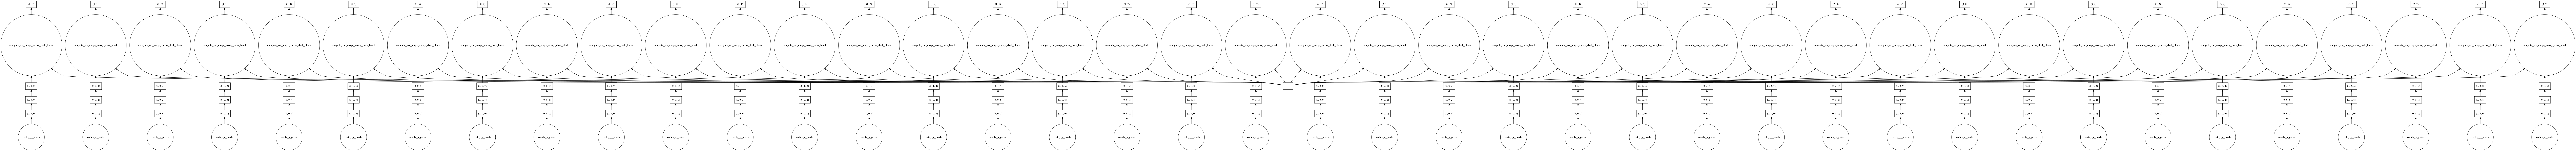

In [29]:
Oa13_radiance.data.visualize()

Let's load the reprojected band into memory and see how long it takes:

In [30]:
with measure_time(tag='Oa13_radiance.load', logger=logger):
    Oa13_radiance = Oa13_radiance.load()

Oa13_radiance.load: took 29085.75ms


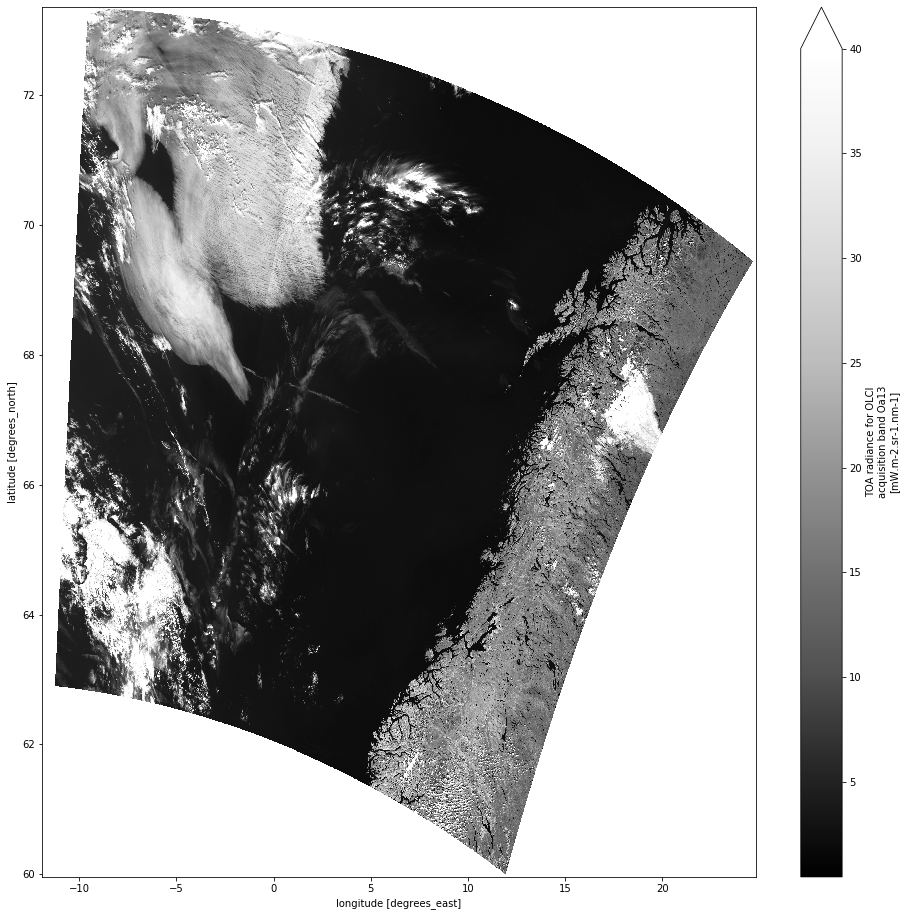

In [33]:
Oa13_radiance.plot.imshow(figsize=(16,16), vmax=40, cmap='Greys_r')

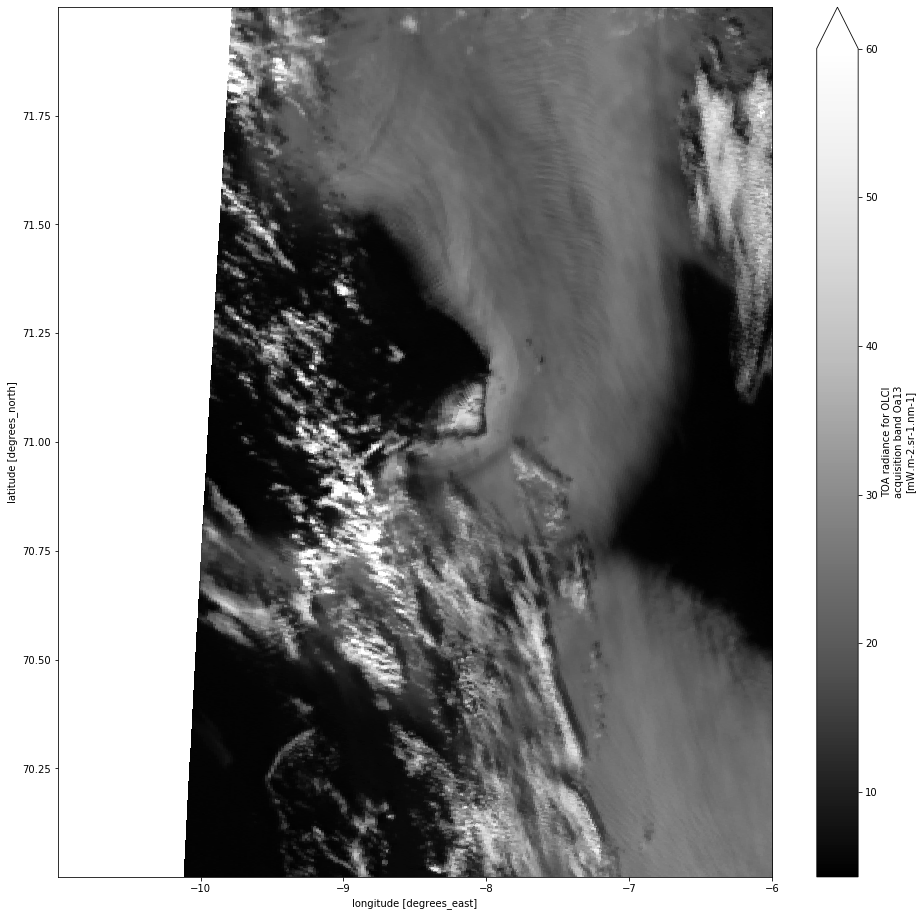

In [32]:
Oa13_radiance.sel(longitude=slice(-11, -6), latitude=slice(70,72)).plot.imshow(figsize=(16,16), vmax=60, cmap='Greys_r')